# Cài đặt thư viện

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 36.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b7b4ba76bac84320eae82c2ce3c6971554b1ee4e54eabfd2def56a38ed49e375
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
! gdown https://drive.google.com/uc?id=1z1yWXfKVKwohiLca_3mRgJXfkFt7mxbS
! gdown https://drive.google.com/uc?id=1mTnou0wDlJkJjRwJW-NUG6j0W8ztS0mN
! gdown https://drive.google.com/uc?id=1taweUUv1KdFc2PoL557U-p8DTKBRs0GQ
! gdown https://drive.google.com/uc?id=1tW98OX8GoafbnGQEOBY_frSV0pT88GMx

Downloading...
From: https://drive.google.com/uc?id=1z1yWXfKVKwohiLca_3mRgJXfkFt7mxbS
To: /content/train.csv
100% 1.62M/1.62M [00:00<00:00, 50.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mTnou0wDlJkJjRwJW-NUG6j0W8ztS0mN
To: /content/test.csv
100% 442k/442k [00:00<00:00, 29.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1taweUUv1KdFc2PoL557U-p8DTKBRs0GQ
To: /content/dev.csv
100% 177k/177k [00:00<00:00, 48.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tW98OX8GoafbnGQEOBY_frSV0pT88GMx
To: /content/vietnamese-stopwords-dash.txt
100% 20.5k/20.5k [00:00<00:00, 33.7MB/s]


In [ ]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 4.6 MB/s 
     |████████████████████████████████| 743 kB 49.7 MB/s 


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import pandas as pd
from IPython.core.display import display
from pyspark.ml.feature import(
    Tokenizer,
    HashingTF,
    IDF,
    CountVectorizer
)
from pyspark.ml.classification import LogisticRegression,NaiveBayes,LinearSVC,DecisionTreeClassifier,RandomForestClassifier, OneVsRest
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from pyvi import ViTokenizer
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
spark = SparkSession.builder.getOrCreate()

In [ ]:
# load data
train = pd.read_csv("train.csv", index_col=False)
dev = pd.read_csv("dev.csv", index_col=False)
test = pd.read_csv("test.csv", index_col=False)

train.reset_index(drop=True)

print(len(train))
print(len(dev))
print(len(test))

24048
2672
6680


# Xử lý data


In [ ]:
#pre-process

STOPWORDS = 'vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    text = text.lower() if lowercased else text
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text if len(text) > 1 else ''
    
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [ ]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)

train = pd.DataFrame({'text': train_X, 'labels': train_y})
dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
test = pd.DataFrame({'text': test_X, 'labels': test_y})


In [ ]:
train = pd.DataFrame({'text': train_X, 'labels': train_y})
dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
test = pd.DataFrame({'text': test_X, 'labels': test_y})

In [ ]:
train = train[train.text != '']
test = test[test.text != '']
dev = dev[dev.text != '']

In [ ]:
trainDataset = spark.createDataFrame(train)
testDataset = spark.createDataFrame(test)
devDataset =  spark.createDataFrame(dev)

# Load data clean

In [ ]:
! gdown https://drive.google.com/uc?id=1GjQ4ZXSfTGYSb5WauBegS62EXirK4fug
! gdown https://drive.google.com/uc?id=1lzOIEmOlB7lkb0gaUm_lrb5k-PDOq5u7
! gdown https://drive.google.com/uc?id=1SSnCct-pu36WZe9Qfy1m96qgYHyt0g8a
! gdown https://drive.google.com/uc?id=1tW98OX8GoafbnGQEOBY_frSV0pT88GMx

Downloading...
From: https://drive.google.com/uc?id=1GjQ4ZXSfTGYSb5WauBegS62EXirK4fug
To: /content/dev_clean.csv
100% 107k/107k [00:00<00:00, 35.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lzOIEmOlB7lkb0gaUm_lrb5k-PDOq5u7
To: /content/test_clean.csv
100% 270k/270k [00:00<00:00, 88.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SSnCct-pu36WZe9Qfy1m96qgYHyt0g8a
To: /content/train_clean.csv
100% 1.00M/1.00M [00:00<00:00, 61.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tW98OX8GoafbnGQEOBY_frSV0pT88GMx
To: /content/vietnamese-stopwords-dash.txt
100% 20.5k/20.5k [00:00<00:00, 34.5MB/s]


In [ ]:
trainDataset = spark.read.csv('train_clean.csv',\
                     header=True, inferSchema=True)
testDataset = spark.read.csv('test_clean.csv',\
                     header=True, inferSchema=True)
devDataset =  spark.read.csv('dev_clean.csv',\
                     header=True, inferSchema=True)


# Show data

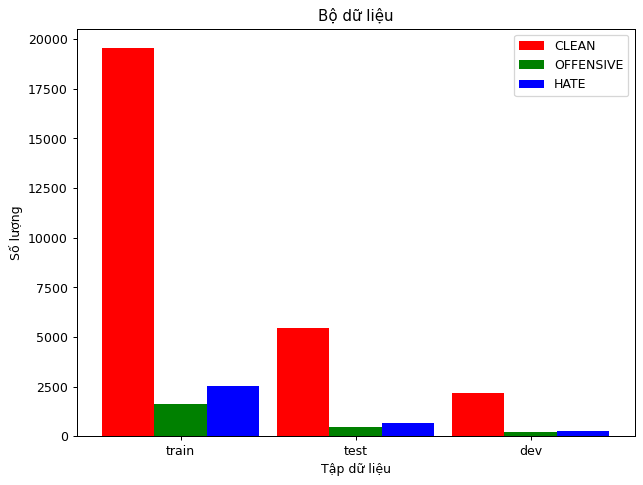

In [ ]:
figure(figsize=(8, 6), dpi=90)
train0 = trainDataset.filter("labels == 0").count()
train1 = trainDataset.filter("labels == 1").count()
train2 = trainDataset.filter("labels == 2").count()
test0 = testDataset.filter("labels == 0").count()
test1 = testDataset.filter("labels == 1").count()
test2 = testDataset.filter("labels == 2").count()
dev0 = devDataset.filter("labels == 0").count()
dev1 = devDataset.filter("labels == 1").count()
dev2 = devDataset.filter("labels == 2").count()
thuoctinh = ['train','test','dev']
label0 = [train0,test0,dev0]
label1 = [train1,test1,dev1]
label2 = [train2,test2,dev2]
index = np.arange(3)
width = 0.3
plt.bar(index,label0,width,color='red',label='CLEAN')
plt.bar(index+width,label1,width,color='green',label='OFFENSIVE')
plt.bar(index+2*width,label2,width,color='blue',label='HATE')
plt.title("Bộ dữ liệu")
plt.ylabel("Số lượng")
plt.xlabel("Tập dữ liệu")
plt.xticks(index+width,thuoctinh)
plt.legend()
plt.show()

# RUN model pipeline 1


In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol= "word1" )
count_vec = CountVectorizer(inputCol = 'word1', outputCol = 'out_count')
idf = IDF(
    inputCol = "out_count",
    outputCol = "features",
    minDocFreq = 5,
)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5445
           1       0.30      0.33      0.31       444
           2       0.44      0.43      0.43       688

    accuracy                           0.81      6577
   macro avg       0.55      0.55      0.55      6577
weighted avg       0.82      0.81      0.81      6577



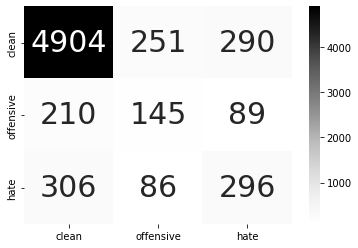

In [ ]:
lr_LogisticRegression = LogisticRegression(labelCol= "labels")
pipeline_LogisticRegression = Pipeline(stages=[tokenizer,count_vec,idf, lr_LogisticRegression])
model_LogisticRegression = pipeline_LogisticRegression.fit(trainDataset)
test_df = model_LogisticRegression.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      5445
           1       0.28      0.33      0.30       444
           2       0.37      0.62      0.46       688

    accuracy                           0.78      6577
   macro avg       0.53      0.60      0.55      6577
weighted avg       0.83      0.78      0.80      6577



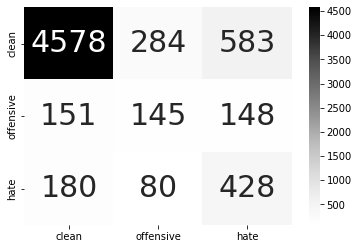

In [ ]:
nb = NaiveBayes(labelCol ="labels",featuresCol ="features", smoothing=1.0, modelType="multinomial",)
pipeline_NaiveBayes = Pipeline(stages=[tokenizer,count_vec,idf, nb])
model_NaiveBayes = pipeline_NaiveBayes.fit(trainDataset)
test_df = model_NaiveBayes.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      5445
           1       0.48      0.07      0.13       444
           2       0.59      0.16      0.25       688

    accuracy                           0.84      6577
   macro avg       0.64      0.41      0.43      6577
weighted avg       0.80      0.84      0.79      6577



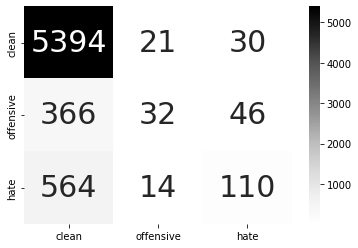

In [ ]:
dtc = DecisionTreeClassifier(labelCol ="labels",featuresCol ="features", maxBins = 5129)
pipeline_DecisionTree = Pipeline(stages=[tokenizer,count_vec,idf, dtc])
model_DecisionTree = pipeline_DecisionTree.fit(trainDataset)
test_df = model_DecisionTree.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5445
           1       0.00      0.00      0.00       444
           2       0.00      0.00      0.00       688

    accuracy                           0.83      6577
   macro avg       0.28      0.33      0.30      6577
weighted avg       0.69      0.83      0.75      6577



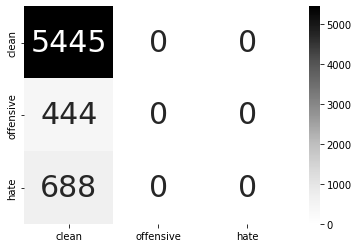

In [ ]:
rfc = RandomForestClassifier(labelCol ="labels",featuresCol ="features", numTrees=5, maxBins = 5129)
pipeline_RandomForest = Pipeline(stages=[tokenizer,count_vec,idf, rfc])
model_RandomForest = pipeline_RandomForest.fit(trainDataset)
test_df = model_RandomForest.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5445
           1       0.38      0.29      0.33       444
           2       0.53      0.44      0.48       688

    accuracy                           0.84      6577
   macro avg       0.60      0.56      0.58      6577
weighted avg       0.83      0.84      0.84      6577



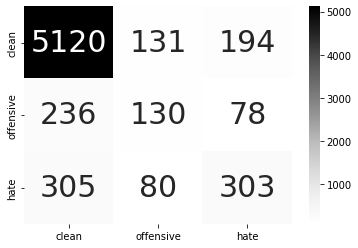

In [ ]:
df = trainDataset.selectExpr("text","labels as label")
df1 = testDataset.selectExpr("text","labels as label")
df2 = devDataset.selectExpr("text","labels as label")
lsvc = LinearSVC(labelCol ="label", featuresCol ="features")
ovr = OneVsRest(classifier=lsvc)
pipeline_lsvc = Pipeline(stages=[tokenizer,count_vec,idf, ovr])
model_lsvc = pipeline_lsvc.fit(df)
test_df = model_lsvc.transform(df1)
evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['label']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

# RUN model pipeline 2


In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol= "word1" )
hashing_tf= HashingTF(
    inputCol= "word1",
    outputCol= "term",
)
idf = IDF(
    inputCol = "term",
    outputCol = "features",
    minDocFreq = 5,
)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5445
           1       0.28      0.31      0.30       444
           2       0.44      0.43      0.44       688

    accuracy                           0.81      6577
   macro avg       0.54      0.55      0.55      6577
weighted avg       0.81      0.81      0.81      6577



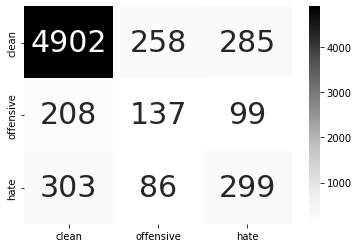

In [ ]:
lr_LogisticRegression = LogisticRegression(labelCol= "labels")
pipeline_LogisticRegression = Pipeline(stages=[tokenizer,hashing_tf,idf, lr_LogisticRegression])
model_LogisticRegression = pipeline_LogisticRegression.fit(trainDataset)
test_df = model_LogisticRegression.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5445
           1       0.61      0.06      0.10       444
           2       0.51      0.35      0.41       688

    accuracy                           0.85      6577
   macro avg       0.66      0.46      0.48      6577
weighted avg       0.82      0.85      0.81      6577



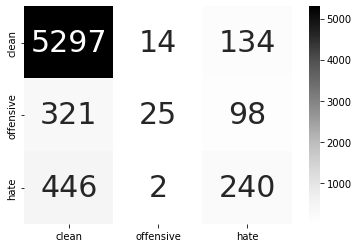

In [ ]:
nb = NaiveBayes(labelCol ="labels",featuresCol ="features", smoothing=1.0, modelType="multinomial",)
pipeline_NaiveBayes = Pipeline(stages=[tokenizer,hashing_tf,idf, nb])
model_NaiveBayes = pipeline_NaiveBayes.fit(trainDataset)
test_df = model_NaiveBayes.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5445
           1       0.00      0.00      0.00       444
           2       0.49      0.17      0.25       688

    accuracy                           0.83      6577
   macro avg       0.45      0.39      0.39      6577
weighted avg       0.75      0.83      0.78      6577



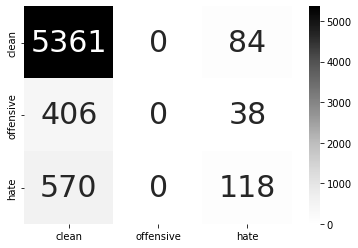

In [ ]:
dtc = DecisionTreeClassifier(labelCol ="labels",featuresCol ="features", maxDepth=3,maxBins = 15)
pipeline_DecisionTree = Pipeline(stages=[tokenizer,hashing_tf,idf, dtc])
model_DecisionTree = pipeline_DecisionTree.fit(trainDataset)
test_df = model_DecisionTree.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5445
           1       0.00      0.00      0.00       444
           2       0.00      0.00      0.00       688

    accuracy                           0.83      6577
   macro avg       0.28      0.33      0.30      6577
weighted avg       0.69      0.83      0.75      6577



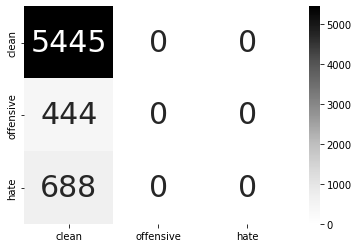

In [ ]:
rfc = RandomForestClassifier(labelCol ="labels",featuresCol ="features", numTrees=5, maxBins = 5129)
pipeline_RandomForest = Pipeline(stages=[tokenizer,hashing_tf,idf, rfc])
model_RandomForest = pipeline_RandomForest.fit(trainDataset)
test_df = model_RandomForest.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="labels",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['labels']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5445
           1       0.36      0.29      0.32       444
           2       0.52      0.43      0.47       688

    accuracy                           0.84      6577
   macro avg       0.60      0.55      0.57      6577
weighted avg       0.83      0.84      0.83      6577



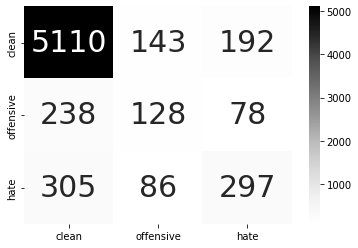

In [ ]:
df = trainDataset.selectExpr("text","labels as label")
df1 = testDataset.selectExpr("text","labels as label")
df2 = devDataset.selectExpr("text","labels as label")
lsvc = LinearSVC(labelCol ="label", featuresCol ="features")
ovr = OneVsRest(classifier=lsvc)
pipeline_lsvc = Pipeline(stages=[tokenizer,hashing_tf,idf, ovr])
model_lsvc = pipeline_lsvc.fit(df)
test_df = model_lsvc.transform(df1)
evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName="accuracy")
accuracy_test = evaluator.evaluate(test_df)
# Show out the confusion matrix
y_true = test_df.select(['label']).collect()
y_pred = test_df.select(['prediction']).collect()
print(classification_report(y_true, y_pred))
cf1 = confusion_matrix(y_true, y_pred)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
model_NaiveBayes.save("model_NaiveBayes")

# Load data real time

In [ ]:
import pyspark
!pip install findspark
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import pandas as pd
from IPython.core.display import display
import seaborn as sns
spark = SparkSession.builder.getOrCreate()

In [ ]:
cd /content/drive/MyDrive/BigData_project

/content/drive/MyDrive/BigData_project


In [ ]:
import pyspark
from IPython.display import display, clear_output
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as f
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql.functions import udf
from pyspark.sql.streaming import DataStreamReader
import html
# SETTINGS
IN_PATH = "/content/drive/MyDrive/BigData_project/data_real_time"

timestampformat = "EEE MMM dd HH:mm:ss zzzz yyyy"
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
spark = SparkSession.builder.appName("BigdataProject").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
schema = spark.read.json(IN_PATH).limit(10).schema
spark_reader = spark.readStream.schema( schema)
streaming_data_raw = (spark_reader.json(IN_PATH).
                    select("id",f.col("datetime").alias("timestamp"),f.col("author.name").alias("user"),
                    "message",).coalesce(1))
stream_writer = (streaming_data_raw.writeStream.queryName("data").trigger(processingTime="5 seconds").outputMode("append").format("memory"))
query = stream_writer.start()

In [ ]:
from pyspark.ml import PipelineModel
model = PipelineModel.load("/content/model_NaiveBayes")

In [ ]:
from pyspark.ml.feature import (StopWordsRemover, Tokenizer, HashingTF, IDF,)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import pandas as pd
from pyvi import ViTokenizer
import re
import numpy as np
!pip install pyvi
STOPWORDS = '/content/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r", encoding="utf8") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    text = text.lower() if lowercased else text
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    return text

def pre_process_features(X, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
    return X

In [ ]:
if streaming_data_raw.isStreaming:
    from time import sleep
    for x in range(0, 2909):
        try:
            #print(query.isActive)
            print("Showing live view nefreshed eveny 10 seconds")
            print(f"Seconds passed: {x*10}")
            result = spark.sql(f"SELECT * from {query.name}")
            x = result.toPandas()
            X_train = x['message']
            train_X = pre_process_features(X_train, tokenized=True, lowercased = False)
            train = pd.DataFrame({'text': train_X})
            trainDataset = spark.createDataFrame(train)
            raw_sentiment = model.transform(trainDataset)
            sentiment = raw_sentiment.select("text",f.col("prediction").alias("user_sentiment"))
            count = spark.sql(f"SELECT * FROM {query.name}").count()
            print(f"Số lượng comment tính tới thời điểm hiện tại: {count}")
            negative_0 = (
                            sentiment.filter("user_sentiment == 0.0")
                            .select(f.col("user_sentiment").alias("CLEAN (non hate)"))
                            .agg(f.count("CLEAN (non hate)"))
                        )
            negative_1 = (
                            sentiment.filter("user_sentiment == 1.0")
                            .select(f.col("user_sentiment").alias("OFFENSIVE"))
                            .agg(f.count("OFFENSIVE"))
                        )
            negative_2 = (
                            sentiment.filter("user_sentiment == 2.0")
                            .select(f.col("user_sentiment").alias("HATE"))
                            .agg(f.count("HATE"))
                        )
            d = {'sentiment': ['CLEAN (non hate)','OFFENSIVE','HATE'], 'count': [negative_0.collect()[0][0],negative_1.collect()[0][0],negative_2.collect()[0][0]]}
            df = pd.DataFrame(data=d)
            display(df)
            sleep(10)
            clear_output (wait= True)
        except KeyboardInterrupt:
            print("break")
            break
    print( "Live view ended")
else:
    print("Not streaming")

Showing live view nefreshed eveny 10 seconds
Seconds passed: 20
Số lượng comment tính tới thời điểm hiện tại: 1298


,sentiment,count
0,CLEAN (non hate),1292
1,OFFENSIVE,0
2,HATE,6


+--------------------+--------------+
|                text|user_sentiment|
+--------------------+--------------+
|: red_heart : : r...|           0.0|
|: red_heart : : r...|           0.0|
|: red_heart : : r...|           0.0|
|: red_heart : : r...|           0.0|
|: red_heart : : r...|           0.0|
+--------------------+--------------+
only showing top 5 rows



None

break
Live view ended
